# Solución Prueba Técnica, Jully Paola Peña Pacheco

## Análisis Preliminar de los datos

Inicialmente se importan algunas librerias comunmente útiles para el tratamiento de datos. No todas las librerias usadas a lo largo del código  son importadas aqui; en general, cada libreria es agregada conforme la necesidad y no con una evaluación a priori de su utilidad dentro de la tarea a desarrollar.

In [37]:
import pandas as pd
import numpy as np
import re

Como primer paso, fue hecho un examen general de la información contenida en el archivo Train.csv. De este examen se concluyó que el conjunto de datos presenta un formato bastante irregular, con signos de puntuación dispersos en partes diferentes de cada línea. Eso es importante porque signos como la coma, el punto y coma, o las comillas pueden generar errores a la hora de separar la información de cada columna; de hecho en el primer intento de importar los datos de Training con pandas (read_csv es una forma muy práctica para obtener los datos en un dataframe, lo que facilita su posterior análisis) se obtiene el error: "Error tokenizing data. C error: Expected 3 fields in line 37569, saw 5", al examinar la línea referida, resulta que las comas dentro de la descripción están fuera de las comillas que le indicarian que todo hace parte del mismo "string". Como no se sabe si otras lineas presentan el mismo problema, en este o en cualquier otro conjunto de datos con los que se vaya a trabajar en esta tarea, se resolvió automatizar la separación de los 3 items presentes en cada fila en una forma que resulte funcional también para otros conjuntos de datos. Sin embargo, es claro que para esto debe asumirse que los datos no vienen en un formato totalmente desordenado, sino que conservan ciertas caraterísticas comunes; en este caso, la característica común es que la primera y última comas son las que separan el texto 'title' de 'label' y de 'is_validated_by_human', respectivamente. Esta separación, y la definición de un dataframe con todos los datos es implementada en la celda a seguir.

In [38]:
Train_set = open('Train.csv','r').readlines()
Val_set = open('Validation.csv','r').readlines()

def separate_cols(file):
    labels=[]
    texts=[]
    human_validation=[]
    
    for i in file:
        i = i.split(',')
        labels.append(i[0])
        texts.append(' '.join(i[1:-1]))
        human_validation.append(i[-1])
    
    df = pd.DataFrame(list(zip(labels[1::], texts[1::], human_validation[1::])),
               columns =['Label', 'Text', 'Human_validated'])
           
    return df



def_train_set = separate_cols(Train_set)
#print(def_train_set.dtypes)

print(np.size(def_train_set['Label']), np.size(def_train_set['Text']), np.size(def_train_set['Human_validated']))
def_train_set.head()

38705 38705 38705


,Label,Text,Human_validated
0,TELEPHONES,Teléfono Inalambrico Duo Motorola M700-2 + Han...,YES;;;\n
1,NOTEBOOKS,Acer Aspire 7520 Notebook 17 Disco Ssd + Hdd ...,YES;;;\n
2,"""TABLETS","""""Tablet Pc Box 7 Quad 1gb 8gb Doble Cam ...","YES"";;;\n"
3,NOTEBOOKS,Notebook Hp X360 15.6 Intel I5 1tb 8gb Win10 T...,YES;;;\n
4,NOTEBOOKS,Notebook Hp 240 G5 Freedos Core I3 Dvd Hdmi 4g...,YES;;;\n


Ahora que los datos están separados en las tres columnas deseadas, leyenda, textos, y validación humana, se hace una verificación de las categorías identificadas en el conjunto de datos:


In [39]:
def_train_set['Label'].unique()

array(['TELEPHONES', 'NOTEBOOKS', '"TABLETS', 'TABLETS', 'CELLPHONES',
       '"NOTEBOOKS', '"CELLPHONES', '"TELEPHONES'], dtype=object)

El hecho que el nombre de algunas categorias contenga caracteres adicionales hace que estas sean tomadas como categorias diferentes. Para corregir esto, se utilizan  "regular expressions" que remueven todo caracter no alfa-numérico. El proceso de romoción de caracteres no alpha-numericos se hará también para la última columna del dataframe principal:

In [40]:
def remove_non_alphan(column, separator):
    def_column = []  
    for label in column:
        label = def_column.append(re.sub(r'\W+', separator, label))
    return def_column
    
#print (def_labels[0:10])
def_labels = remove_non_alphan(def_train_set['Label'], separator = '')
def_HV = remove_non_alphan(def_train_set['Human_validated'], separator = '')

print(np.size(def_labels))
print(np.size(def_HV))

def_train_set['Label'] = def_labels
def_train_set['Human_validated'] = def_HV

print(def_train_set['Label'].unique())
print(def_train_set['Human_validated'].unique())

def_train_set.head()

38705
38705
['TELEPHONES' 'NOTEBOOKS' 'TABLETS' 'CELLPHONES']
['YES' 'NO']


,Label,Text,Human_validated
0,TELEPHONES,Teléfono Inalambrico Duo Motorola M700-2 + Han...,YES
1,NOTEBOOKS,Acer Aspire 7520 Notebook 17 Disco Ssd + Hdd ...,YES
2,TABLETS,"""""Tablet Pc Box 7 Quad 1gb 8gb Doble Cam ...",YES
3,NOTEBOOKS,Notebook Hp X360 15.6 Intel I5 1tb 8gb Win10 T...,YES
4,NOTEBOOKS,Notebook Hp 240 G5 Freedos Core I3 Dvd Hdmi 4g...,YES


En la celda anterior, fue verificado que las categorias presentes son las correctas tanto en términos del tipo de producto, como en si este fue verificado por un humano o no. La columna central del dataframe irá requerir también de una limpieza de caracteres, palabras no significativas, y otros, pero esta no es necesária para este primer análisis sobre la distribución general de los datos. Así, el tratamiento completo de los textos en la columna 'Text', se hará más adelante, como preparación para la implementación del modelo predictivo.

### Análisis de distribución de los datos

Habiendo depurado el contenido de las columnas 'Labels' y 'Human_validated', es posible hacer un análisis sobre la presencia de 'skewed classes', lo cuál es un parámetro importante a tener en cuenta para la implementación de un algoritmo de clasificación. Para esto, se van a contar los elementos de cada clase presentes en el conjunto de datos:

In [41]:
print(def_train_set['Label'].value_counts())
print(def_train_set['Human_validated'].value_counts())

TELEPHONES    14037
CELLPHONES    12253
NOTEBOOKS      6615
TABLETS        5800
Name: Label, dtype: int64
NO     32893
YES     5812
Name: Human_validated, dtype: int64


Con relación a las cuatro categorías de clasificación, la cantidad de elementos marcados como 'TELEPHONES' es mas de dos veces la de los marcados como 'TABLETS', esto puede generar inconvenientes a la hora de entrenar un modelo, a menos que los datos de entrada contengan características unívocas como para que el agoritmo aprenda a identificar los elementos de una determinada categoria con confianza, aún con una cantidad menor de datos en esa categoría. En ese caso, 5800 datos puede ser una cantidad suficiente para que el algoritmo aprenda a diferenciar los elementos de la categoria 'TABLETS', pero este no es el único factor a considerar. 

Con relación a la cantidad de datos validados por humanos, estos están presentes en una cantidad que es al menos 6 veces menor que la de datos no validados por humanos. Normalmente podria asumirse que los datos validados son de mejor calidad, o sea que tenemos confianza en su clasificación. En ese caso, seria preferible entrenar el modelo apenas utilizando esos datos óptimizados, pues datos con clasificación errónea pueden aumentar el ruido y ser de hecho contraproducente tomarlos en cuenta. Aqui sin embargo, al no tener ninguna información de las métricas de evaluación del algoritmo que generó los datos, y teniendo en cuenta que el texto que describe un aparato electrónico puede contener características que pueden resultar confusas incluso para un humano cuando la clasificación es hecha apenas a partir de ese texto, no se considerará que los datos validados por humanos sean de mejor calidad, así que no se hará a priori ninguna selección de los datos a utilizar para el entrenamiento del modelo con base en este critério. 

Como no hay datos numéricos en ninguna de las columnas del dataframe, no se considera necesário una búsqueda de valores nulos, y por el tamaño de los subconjuntos de cada subcategoria, tampoco se considera necesário buscar si hay celdas vacias.

Con esto, se hará un primer intento de entrenar un algoritmo utilizando todos los datos disponibles. Esto sólo es factible en un algoritmo que corra relativamente rápido y que sea simple de implementar. Para esto se usará un modelo de clasificación "one vs. rest" que utiliza un algoritmo de Suport Vector Machine con kernel lineal.

## Bag of words

Los inputs del algoritmo se pasarán en el formato de un "Bag of Words" generado por CountVectorizer. Esta elección de debe a que, en este conjunto de datos específico, las palabras utilizadas en los títulos de los productos no se encajan dentro de un tipo de lenguaje en el que sea importante la identificación de un contexto semántico. Como hipótesis, se tiene que la asociación de palabras en este contexto podría de hecho empeorar el proceso de aprendizaje del algoritmo porque los productos de las diferentes categorías pueden tener muchas características comunes como marca, o tamanho de memória, que no tienen relación con el tipo de producto.

In [42]:
from sklearn.feature_extraction.text import CountVectorizer


vectorizer = CountVectorizer(binary=True)

Antes de vectorizar los textos, serán removidos los caracteres no alphanuméricos con la intuición que esto pueda reducir el tiempo de computo de la vectorización y consecuentemente del entrenamiento del algoritmo, aunque no se espera que eso ayude a mejorar la clasificación porque de todas formas hay dentro de los textos muchos códigos que no son realmente palabras y en los cuales la remoción de esos caracteres no hace diferencia.

In [43]:
train_numpy = def_train_set['Text'].to_numpy()


Train_text = remove_non_alphan(train_numpy, separator = ' ')
#print(Train_text)
train_x_vectors = vectorizer.fit_transform(Train_text)

#print(vectorizer.get_feature_names())
print(type(train_x_vectors))
print(train_x_vectors[0])

<class 'scipy.sparse.csr.csr_matrix'>
  (0, 16725)	1
  (0, 9837)	1
  (0, 6968)	1
  (0, 12245)	1
  (0, 11440)	1
  (0, 9115)	1
  (0, 5110)	1
  (0, 9672)	1


In [44]:
y_train = def_train_set['Label'].to_numpy()
print(y_train[0:10])

['TELEPHONES' 'NOTEBOOKS' 'TABLETS' 'NOTEBOOKS' 'NOTEBOOKS' 'TABLETS'
 'TABLETS' 'NOTEBOOKS' 'TABLETS' 'TABLETS']


## Primer intento de modelo predictivo con LinearSVM

Los modelos Suport Vector Machine son comunes para aprendizaje supervisado por su versatilidad en el trabajo con datos multidimensionales y su eficiente uso de memória. El modelo Linear Suport Vector Machine (LSVM) fue escogido en este caso sobre el modelo base SVM porque al ser un modelo de clasificación "one vs all" en vez de "one vs. one", este se entrena más rapidamente, lo que es una ventaja cuando el conjunto de datos es grande, o cuando se quiere hacer un test inicial, como es el caso aquí. Además, este soporta como entrada tanto matrices de tipo "sparse", como la dada por CounterVectorizer, como matrices "densas" como las dadas por Tokenizer. Así, en caso que sea identificado que una u otra técnica de vectorización del texto es más adecuada, el modelo puede ser adaptado.

In [45]:
from sklearn.svm import LinearSVC


## FITTING

clf_Lsvm = LinearSVC()
Model1 = clf_Lsvm.fit(train_x_vectors, y_train)

## PREDICTING IN AN EXAMPLE

test_x = vectorizer.transform(['Motorola Moto G5 Plus Con Funda Y Vidrio De Regalo! Nuevos!'])
Model1.predict(test_x)

array(['TELEPHONES'], dtype=object)

Ahora se deben evaluar las métricas del modelo. Para esto se preparan primero los datos del conjunto de validación, que seran los contenidos en el archivo Validation.csv:

In [46]:
## PREPARATION OF LABELS AND HUMAN VALIDATED COLUMNS

def_val_set = separate_cols(Val_set)
def_val_set.head()

def_val_labels = remove_non_alphan(def_val_set['Label'], separator='')
def_val_HV = remove_non_alphan(def_val_set['Human_validated'], separator='')

print(np.size(def_val_labels))
print(np.size(def_val_HV))
def_val_set['Label'] = def_val_labels
def_val_set['Human_validated'] = def_val_HV

def_val_set.head()

## PREPARATION OF THE TEXT USING COUNTVECTORIZER

val_text_numpy = def_val_set['Text'].to_numpy()
Val_text = remove_non_alphan(val_text_numpy, separator = ' ')
val_x_vectors = vectorizer.transform(Val_text)


val_label_numpy = def_val_set['Label'].to_numpy()


1245
1245


Se evaluará la métrica F1 porque es esta es útil en conjuntos en que la cantidad de datos no es la misma para todas las categorias, y porque permite ver el rendimiento del modelo para cada una de las categorias.

In [47]:
from sklearn.metrics import f1_score

print(f1_score(val_label_numpy, Model1.predict(val_x_vectors), average=None, labels=['CELLPHONES', 'NOTEBOOKS', 'TABLETS', 'TELEPHONES']))

[0.25433526 0.9888412  0.98224852 0.        ]


El factor F1 indica que el modelo falla contundentemente al intentar predecir ejemplos de celulares y teléfonos. Posibles problemas en la distribución de los datos habian sido identificados antes, pero resulta curioso que  las peores métricas sean precisamente las de las dos categorias con más elementos. Eso indica que la calidad de los datos está comprometida, principalmente para las categorias 'CELLPHONES' y 'TELEPHONES'.

Sin embargo, al evaluar también el conjunto de validación utilizado, sobre el cuál se calcula la métrica, se tiene que este, con sus 1245 elementos, representa apenas un 3% del total de los datos sumados en los conjuntos de entrenamiento y validación, cuando normalmente deberia ser de alrededor de 20%. 

Para identificar mejor la causa de los malos resultados en la métrica del modelo, se hará a continuación un análisis mas detallado de la distribución de los datos tanto en el conjunto de entrenamiento cuanto en el de validación.

In [48]:
print(def_val_set['Label'].value_counts())
print(def_val_set['Human_validated'].value_counts())

NOTEBOOKS     583
TABLETS       512
CELLPHONES    141
TELEPHONES      9
Name: Label, dtype: int64
YES    1245
Name: Human_validated, dtype: int64


De la distribución de los datos en este conjunto de validación, resulta claro que siempre será difícil obtener métricas estadísticamente significativas para las categorias 'CELLPHONES' y 'TELEPHONES' porque hay muy pocos elementos de esas categorías en ese conjunto. Esto es claramente visto en la matriz de confusión mostrada a continuación, en la que se ve que los 9 ejemplos de 'TELEPHONES' fueron predichos como siendo 'CELLPHONES'. Observese por ejemplo que en la categoria 'TABLETS' (linea 3) mas de 9 ejemplos fueron clasificados en la categoria equivocada, pero esto no afecta demasiado la métrica porque los 14 ejemplos mal clasificados representan apenas un 2.7 % del total, mientras que en el caso de la categoria 'CELLPONES', 9 ejemplos mal clasificados corresponden al 100 % de los datos.

Otro item a resaltar, y que puede ser importante a la hora de evaluar si las metricas calculadas son realmente representativas del modelo, es el hecho que este conjunto de validación solamente contiene datos validados por usuários humanos.

In [49]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(val_label_numpy, Model1.predict(val_x_vectors)))

[[ 22   0   0 119]
 [  0 576   4   3]
 [  1   6 498   7]
 [  9   0   0   0]]


## Análisis a posteriori de los datos

Para tener una idea de como la clasificación de una categoria varia de acuerdo a su validación por usuário, y tener una idea de si ese parámetro representa o no una mejora en la calidad del input del conjunto de entrenamiento, puede ser interesante ver si la proporción de items validados por personas varia de una categoria para otra.
        

In [50]:
grouped_train = def_train_set.groupby(['Label','Human_validated']).count()
grouped_train

Text
Label      Human_validated       
CELLPHONES NO               11594
           YES                659
NOTEBOOKS  NO                3891
           YES               2724
TABLETS    NO                3412
           YES               2388
TELEPHONES NO               13996
           YES                 41

dict_keys(['CELLPHONES', 'NOTEBOOKS', 'TABLETS', 'TELEPHONES'])
dict_keys(['CELLPHONES', 'NOTEBOOKS', 'TABLETS', 'TELEPHONES']) [659, 2724, 2388, 41] [11594, 3891, 3412, 13996]


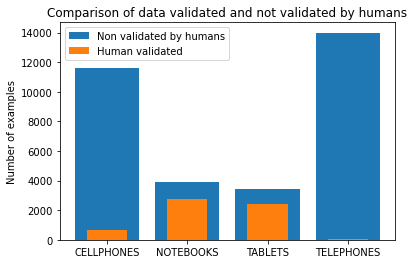

In [51]:
import matplotlib.pyplot as plt

validated_dummy = pd.get_dummies(def_train_set['Human_validated'])
#print(validated_dummy.head())


def_train_set_dummy = pd.concat([def_train_set, validated_dummy], axis=1)
def_train_set_dummy.head()

symbols = def_train_set_dummy.groupby(['Label'])

print(symbols.groups.keys())

GROUPS = symbols.groups.keys()
YES=[]
NO=[]
for i in symbols.groups:
    a = symbols.get_group(i)
    yes = a['YES'].sum()
    no = a['NO'].sum()
    YES.append(yes)
    NO.append(no)

   

print(GROUPS, YES, NO)

plt.bar(GROUPS, NO, width =0.8, label="Non validated by humans")
plt.bar(GROUPS, YES, width =0.5, label= 'Human validated')
plt.title('Comparison of data validated and not validated by humans')
plt.ylabel('Number of examples')
plt.legend()
plt.show()


Se observa en el cuadro y gráfico de los outputs de las dos celdas anteriores, que los datos validados por humanos pertenecen principalmente a las categorias 'NOTEBOOKS' y 'TABLETS', siendo que de los 5812 datos validados por humanos, 5512 (que corresponde aproximadamente al 88 %) pertenecen a alguna de esas dos categorias.

La otra característica que se observa es que, aunque para todas las categorias el número de ejemplos no validados por humanos supera al de ejemplos validados por humanos, en las categorias 'NOTEBOOKS' y 'TABLETS', el número de ejemplos validados y no validados es del mismo orden de magnitud,  mientras que para las categorias 'CELLPHONES' y 'TELEPHONES', casi el 100 % de los datos son datos no validados por humanos; de hecho, apenas 41 de los 14037 ejemplos de 'TELEPHONES' son datos validados.

Teniendo en cuenta estos dos critérios, y el hecho que un modelo simple es capaz de predecir correctamente una catidad estadísticamente significativa de datos en las categorias 'NOTEBOOKS' y 'TABLETS', se deduce que el tener una gran cantidad de datos no validados por usuários en el conjunto de trainning no es demasiado relevante desde que haya una cantidad similar de datos validados, pero puede ser sufuciente para impedir el aprendizado del modelo si estos datos están presentes en cantidades demasiado importantes con relación a los datos validados por usuários para una categoria específica.

Teniendo esto en cuenta, a continuación se muestran resultados para un modelo entrenado utilizando conjuntos diferentes de datos y validado también en diferentes conjuntos de datos. 

## LSVM - para un conjunto reducido de datos (evaluación del efecto de la cantidad de datos por categoria, y de la importancia de la validación por humanos)

### Preparación del nuevo conjunto de datos

Este nuevo conjunto de entrenamiento es un conjunto reducido que contiene solamente los datos del conjunto de training original que son validados por humanos.

In [52]:
tel = def_train_set[(def_train_set['Label'] == "TELEPHONES") & (def_train_set['Human_validated'] == "YES")]
cel = def_train_set[(def_train_set['Label'] == "CELLPHONES") & (def_train_set['Human_validated'] == "YES")]
tab = def_train_set[(def_train_set['Label'] == "TABLETS") & (def_train_set['Human_validated'] == "YES")]
nob = def_train_set[(def_train_set['Label'] == "NOTEBOOKS") & (def_train_set['Human_validated'] == "YES")]
# tel = def_train_set[(def_train_set['Label'] == "TELEPHONES")].sample(frac=1).reset_index(drop=True)
# cel = def_train_set[(def_train_set['Label'] == "CELLPHONES")].sample(frac=1).reset_index(drop=True)
# tab = def_train_set[(def_train_set['Label'] == "TABLETS")].sample(frac=1).reset_index(drop=True)
# nob = def_train_set[(def_train_set['Label'] == "NOTEBOOKS")].sample(frac=1).reset_index(drop=True)


frames = [tel.head(1000), cel.head(1000), tab.head(1000), nob.head(1000)]

red_set = pd.concat(frames)
red_set = red_set.sample(frac=1).reset_index(drop=True)
print(red_set['Label'].value_counts())
print(red_set['Human_validated'].value_counts())

TABLETS       1000
NOTEBOOKS     1000
CELLPHONES     659
TELEPHONES      41
Name: Label, dtype: int64
YES    2700
Name: Human_validated, dtype: int64


In [53]:
##NEW TRAINING SET PREPARATION

new_train_numpy = red_set['Text'].to_numpy()

new_Train_text = remove_non_alphan(new_train_numpy, separator = ' ')
#print(Train_text)
new_train_x_vectors = vectorizer.transform(new_Train_text)


## NEW LABELS OF THE TRAINING SET

new_y_numpy = red_set['Label'].to_numpy()
#print(new_y_numpy)

### Entrenamiento de modelo con nuevo conjunto de datos

In [54]:
Model2 = clf_Lsvm.fit(new_train_x_vectors, new_y_numpy)

### Probando la predicción de los modelos en un ejemplo

In [55]:
test_x = vectorizer.transform(['Motorola Moto G5 Plus Con Funda Y Vidrio De Regalo! Nuevos!'])
Model2.predict(test_x)

array(['CELLPHONES'], dtype=object)

### Algunas métricas del modelo LSVM entrenado sólo con datos validados por humanos:

Notese que la validación a seguir es hecha sobre el conjunto original de validación del  archivo Validation.csv

In [56]:
from sklearn.metrics import matthews_corrcoef, confusion_matrix


print(Model2.score(val_x_vectors, val_label_numpy))
print(f1_score(val_label_numpy, Model2.predict(val_x_vectors), average=None, labels=['CELLPHONES', 'NOTEBOOKS', 'TABLETS', 'TELEPHONES']))
print(confusion_matrix(val_label_numpy, Model2.predict(val_x_vectors)))

0.9847389558232932
[0.9825784  0.9862543  0.98334966 1.        ]
[[141   0   0   0]
 [  2 574   7   0]
 [  3   7 502   0]
 [  0   0   0   9]]


Las métricas arriba corresponden a las de un modelo entrenado con un conjunto de datos de diferente tamaño para cada categoria, pero todos siendo validados por humanos. En este caso, se observa que cuando las métricas del modelo son calculadas encima de un conjunto en el que todos los datos son también validados por humanos, como es el caso del conjunto de validación dado, el modelo se comporta bastante bien para todas las categorias. Obsérvese que en este caso el entrenamiento fue hecho con cantidades muy diferentes de datos en cada categoria, siendo 1000 para 'TABLETS' y 'NOTEBOOKS', pero apenas 41 para 'TELEPHONES'. Esta diferencia en la cantidad de datos no parece ser un problema pues métricas similares son obtenidas si el modelo se entrena con 41 datos para cada categoria (no mostrado).


Como comentado anteriormente, el conjunto de validación dado no presenta una cantidad estadísticamente significativa de datos en la categoria 'TELEPHONES' por lo que este puede no ser aplicable en general. Por eso, a continuación se presentan estas mismas métricas calculadas encima de un conjunto mas general de datos, de aproximadamente el mismo tamaño que el conjunto de validación inicial (1200 elementos) pero en el que la cantidad de datos para cada categoria es el mismo y presenta además datos validados y no validados por humanos.

### Métricas calculadas para un conjunto de validación heterogéneo en términos de validación por humanos

Los datos a seguir deben ser tomados del mismo training set ya que no hay mas datos disponibles, pero eso, aunque no es lo ideal, no es necesáriamente un problema ya que no todos los datos del conjunto fueron usandos para entrenar el Modelo2, así que no hay una intersección importante entre los conjuntos de entrenamiento y validación.

In [57]:
n_tel = def_train_set[(def_train_set['Label'] == "TELEPHONES")].sample(frac=1).reset_index(drop=True)
n_cel = def_train_set[(def_train_set['Label'] == "CELLPHONES")].sample(frac=1).reset_index(drop=True)
n_tab = def_train_set[(def_train_set['Label'] == "TABLETS")].sample(frac=1).reset_index(drop=True)
n_nob = def_train_set[(def_train_set['Label'] == "NOTEBOOKS")].sample(frac=1).reset_index(drop=True)


n_frames = [n_tel.head(300), n_cel.head(300), n_tab.head(300), n_nob.head(300)]

n_set = pd.concat(n_frames)
n_set = n_set.sample(frac=1).reset_index(drop=True)

n_set.head()
n_train_numpy = n_set['Text'].to_numpy()
n_Train_text = remove_non_alphan(n_train_numpy, separator = ' ')
n_train_x_vectors = vectorizer.transform(n_Train_text)

n_y_train = n_set['Label'].to_numpy()

In [58]:
print(Model2.score(n_train_x_vectors, n_y_train))
print(f1_score(n_y_train, Model2.predict(n_train_x_vectors,), average=None, labels=['CELLPHONES', 'NOTEBOOKS', 'TABLETS', 'TELEPHONES']))
print(confusion_matrix(n_y_train, Model2.predict(n_train_x_vectors,)))

0.525
[0.12151067 0.91331269 0.95469256 0.0113852 ]
[[ 37  31   8 224]
 [  0 295   5   0]
 [  1   4 295   0]
 [271  16  10   3]]


Las métricas arriba corresponden a las del modelo 2 validado en un conjunto que contiene datos validados y no validados por humanos y se observa que esta vez el modelo falla al predecir elementos de las categorias 'CELLPHONES' y 'TELEPHONES'. 

## Generalización del modelo

Pruebas adicionales fueron hechas entrenando el modelo con el mismo número de datos en cada categoria (1000 para cada una), pero con una mezcla de datos validados y no validados por usuários, en ese caso las métricas no son aceptables cuando la validación es hecha sobre el conjunto de validación original (donde todos los datos son validados), pero mejoran al punto del factor F1 ser 0.93, 0.99, 0.98, 0.91 para 'CELLPHONES', 'NOTEBOOKS', 'TABLETS', y 'TELEPHONES', respectivamente, cuando validados sobre este último conjunto heterogéneo de datos en términos de validación por humanos (ver output de las 2 celdas abajo). Estos resultados se consideran válidos pues apenas 4000 de los 38705 datos fueron usados para entrenar el modelo, y tanto en el entrenamiento cuanto en la validación los datos fueron escogidos aleatoriamente.

In [59]:
## DATA TO BE USED AS TRAINING SET FOR TESTING OTHER MODELS

tel2 = def_train_set[(def_train_set['Label'] == "TELEPHONES")].sample(frac=1).reset_index(drop=True)
cel2 = def_train_set[(def_train_set['Label'] == "CELLPHONES")].sample(frac=1).reset_index(drop=True)
tab2 = def_train_set[(def_train_set['Label'] == "TABLETS")].sample(frac=1).reset_index(drop=True)
nob2 = def_train_set[(def_train_set['Label'] == "NOTEBOOKS")].sample(frac=1).reset_index(drop=True)


frames2 = [tel2.head(1000), cel2.head(1000), tab2.head(1000), nob2.head(1000)]

red_set2 = pd.concat(frames2)
red_set2 = red_set2.sample(frac=1).reset_index(drop=True)
print(red_set2['Label'].value_counts())
print(red_set2['Human_validated'].value_counts())


## New training set preparation

new_train_numpy2 = red_set2['Text'].to_numpy()

new_Train_text2 = remove_non_alphan(new_train_numpy2, separator = ' ')

new_train_x_vectors2 = vectorizer.transform(new_Train_text2)


## New labels of the training set

new_y_numpy2 = red_set2['Label'].to_numpy()



TELEPHONES    1000
TABLETS       1000
CELLPHONES    1000
NOTEBOOKS     1000
Name: Label, dtype: int64
NO     3134
YES     866
Name: Human_validated, dtype: int64


In [60]:
LSVM_MODEL = clf_Lsvm.fit(new_train_x_vectors2, new_y_numpy2)

print(LSVM_MODEL.score(n_train_x_vectors, n_y_train))
print(matthews_corrcoef(n_y_train, LSVM_MODEL.predict(n_train_x_vectors)))
print(f1_score(n_y_train, LSVM_MODEL.predict(n_train_x_vectors,), average=None, labels=['CELLPHONES', 'NOTEBOOKS', 'TABLETS', 'TELEPHONES']))
print(confusion_matrix(n_y_train, LSVM_MODEL.predict(n_train_x_vectors,)))

0.9433333333333334
0.9245908495869539
[0.91428571 0.98487395 0.97306397 0.9025974 ]
[[272   0   2  26]
 [  0 293   3   4]
 [  1   2 289   8]
 [ 22   0   0 278]]


### Conclusión sobre los datos

Así, se concluye que para este conjunto de datos, un modelo simple como el LinearSVM es capaz de hacer una predicción relativamente confiable de las categorias (alrededor de 95 % de certeza en media) cuando **entrenado y probado solamente en datos validados por humanos**, y eso es verdad sin importar si el tamaño del conjunto de datos tomado para cada categoria es igual o no (aunque un conjunto mayor de  datos validados por humanos en la categoria 'TELEPHONES' es necesário para tener un resultado estadísticamente significativo). Sin embargo, en ese caso la generalización del modelo no es posible para conjuntos de datos con elementos no validados por humanos. Al mismo tiempo, si el modelo es entrenado con datos validados y no validados por humanos, este será capaz de hacer previsiones también con mas o menos 95 % de certeza en conjuntos de datos igualmente heterogéneos. 

# Probando otros modelos

Con el análisis anterior, ahora es posible concentrarse en la búsqueda y/o refinamiento de un modelo, conociendo las limitaciones del conjunto de datos dado. Para probar la conclusión de que un modelo de clasificación simple servirá relativamente bien cuando entrenado y validado en conjuntos heterogéneos de datos en términos de validación humana, se mostrarán a continuación los resultados para los algortimos de Desicion Trees y K-nearest-neighbors.

## Decision Trees

In [61]:
from sklearn.tree import DecisionTreeClassifier

clf_dec = DecisionTreeClassifier()


## TRAINING THE MODEL

DEC_MODEL = clf_dec.fit(new_train_x_vectors2, new_y_numpy2)


### Probando la predicción del modelo con un ejemplo

In [62]:
test_x = vectorizer.transform(['Motorola Moto G5 Plus Con Funda Y Vidrio De Regalo! Nuevos!'])
DEC_MODEL.predict(test_x)

array(['TELEPHONES'], dtype=object)

### Métricas del modelo Desicion Trees

In [63]:
print(DEC_MODEL.score(n_train_x_vectors, n_y_train))
print(matthews_corrcoef(n_y_train, DEC_MODEL.predict(n_train_x_vectors)))
print(f1_score(n_y_train, DEC_MODEL.predict(n_train_x_vectors,), average=None, labels=['CELLPHONES', 'NOTEBOOKS', 'TABLETS', 'TELEPHONES']))
print(confusion_matrix(n_y_train, DEC_MODEL.predict(n_train_x_vectors,)))

0.9366666666666666
0.9159839630551285
[0.90443686 0.97979798 0.97133221 0.89314195]
[[265   0   2  33]
 [  0 291   3   6]
 [  2   2 288   8]
 [ 19   1   0 280]]


## K-nearest neighbors

In [64]:
from sklearn.neighbors import KNeighborsClassifier

In [65]:
k = 4

## TRAINING THE MODEL

NEIGH = KNeighborsClassifier(n_neighbors = k).fit(new_train_x_vectors2, new_y_numpy2)

NEIGH

KNeighborsClassifier(n_neighbors=4)

### Métricas del modelo K-Neares_neighbors

In [66]:
print(NEIGH.score(n_train_x_vectors, n_y_train))
print(matthews_corrcoef(n_y_train, NEIGH.predict(n_train_x_vectors)))
print(f1_score(n_y_train, NEIGH.predict(n_train_x_vectors,), average=None, labels=['CELLPHONES', 'NOTEBOOKS', 'TABLETS', 'TELEPHONES']))
print(confusion_matrix(n_y_train, NEIGH.predict(n_train_x_vectors,)))

0.9275
0.9034036007905689
[0.91       0.96283784 0.93442623 0.90301003]
[[273   0   7  20]
 [  5 285   5   5]
 [  6   6 285   3]
 [ 16   1  13 270]]


## Conclusión sobre los modelos

Entre los modelos probados, el modelo que mejor predice la categoria a la cual un producto pertenece, basado en su título, es el modelo Linear Suport Vector Machine. En todos los casos, la mejor predicción es hecha para la categoria 'NOTEBOOKS' la cual es la categoria con más datos validados por humanos. 

Los resultados mostrados indican que los datos validados por usuários contienen textos más explicativos que facilitan el trabajo de los modelos de Aprendizado de Máquina, sin embargo, no resulta práctico entrenar los modelos sólo con estos datos "de mejor calidad" si se pretende usar el modelo para hacer predicciones en conjuntos  que contengan una gran proporción de datos no validados por usuários. Para esos casos el mejor conjunto de entrenameinto debe contener datos de ambos tipos, validados y no validados por humanos. 

## Salvando los modelos

Se guardarán los tres modelos simples de predicción entrenados y validados en los mismo conjunto de datos.

In [67]:
import pickle

with open('./LinearSVM.pkl', 'wb') as f: 
    pickle.dump(LSVM_MODEL, f)
    
with open('./DecTree.pkl', 'wb') as f: 
    pickle.dump(DEC_MODEL, f)
    
with open('./K_neigh.pkl', 'wb') as f: 
    pickle.dump(NEIGH, f)

### Como cargar y usar los modelos

Estos modelos pueden ser cargados para ser usados posteriormente así:


with open('./model_name.pkl', 'rb') as f:

    loaded_model = pickle.load(f) 
    
    
y necesitan como datos de entrada matrices tipo sparce de datos de texto procesados con CountVectorizer para las variables independientes, y vectores de formato numpy para los 'labels'. 

Dentro de este archivo, los inputs y labels en ese formato pueden ser obtenidos procesando los datos provenientes de un dataframe (df) así:

df_to_numpy = df['col_text'].to_numpy()
data_clean = remove_non_alphan(new_train_numpy2, separator = ' ')


input_x = vectorizer.transform(data_clean)
label = df['col_label'].to_numpy()




# Test adicionales

Las celdas abajo contienen algunas ideas para refinamiento de modelo y/o testes de hipótesis, pero no hacen parte de la tarea propuesta y pueden ser descartadas de la evaluación de la misma. 

Estas son pruebas muy preliminares usando otras formas de vectorización de los textos, y de un modelo de red neuronal que contiene una 'layer' embedding, pero en la que no fue hecho ningún intento sério de entrenamiento.

## Word Vectors en modelo LinearSVM

Este es un test para ver si una aproximación diferente de la vectorización de los textos mejora el desempeño del modelo. Esta vectorización busca cierta conexión semántica entre las palabras con una pipeline pre-entrenada.

In [68]:
import spacy
nlp = spacy.load("en_core_web_md")

In [69]:
docs = [nlp(text) for text in new_Train_text2]
new_train_x_word_vectors = [x.vector for x in docs]

In [70]:
clf_Lsvm_wv = LinearSVC()
clf_Lsvm_wv.fit(new_train_x_word_vectors, new_y_numpy2)

LinearSVC()

In [71]:
test_x = ['Motorola Moto G5 Plus Con Funda Y Vidrio De Regalo! Nuevos!'] 
test_docs = [nlp(text) for text in test_x]
test_x_word_vectors =  [x.vector for x in test_docs]

clf_Lsvm_wv.predict(test_x_word_vectors)

array(['TELEPHONES'], dtype=object)

In [72]:
docs_val = [nlp(text) for text in n_Train_text]
test_x_word_vectors = [x.vector for x in docs_val]
print (np.size(test_x_word_vectors))
print(np.size(n_y_train))
print(f1_score(n_y_train, clf_Lsvm_wv.predict(test_x_word_vectors), average=None, labels=['CELLPHONES', 'NOTEBOOKS', 'TABLETS', 'TELEPHONES']))


360000
1200
[0.87296417 0.98163606 0.95798319 0.88175676]


Aparentemente la hipótesis inicial de que esta aproximación para la vectorización de los textos no resultaria más adecuada para el caso específico de estos titulos de productos estaba correcta pues este modelo tiene métricas un poco peores que las obtenidas con un simple bag of words.

# Recurrent Neural Network

In [73]:
import tensorflow as tf
from tensorflow import keras

In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [75]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=None, 
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                      lower=True,
                      split=' ',
                      char_level=False,
                      oov_token='<UNK>',
                      document_count=0)

In [76]:
tokenizer.fit_on_texts(new_Train_text2)

In [77]:
tokenizer_config = tokenizer.get_config()
tokenizer_config.keys()

dict_keys(['num_words', 'filters', 'lower', 'split', 'char_level', 'oov_token', 'document_count', 'word_counts', 'word_docs', 'index_docs', 'index_word', 'word_index'])

In [78]:
train_texts_seq = tokenizer.texts_to_sequences(new_Train_text2)
val_texts_seq = tokenizer.texts_to_sequences(n_Train_text)
print(type(train_texts_seq))
train_texts_seq[0:5]

<class 'list'>


[[22, 34, 133, 65, 196, 15, 159, 13, 139, 46, 455],
 [1795, 1187, 6, 899, 560, 1796, 642, 38, 213, 87, 1797],
 [14, 423, 19, 376, 40, 70, 1798],
 [495, 54, 87, 42, 186, 1799, 109, 6, 62, 214],
 [643, 1800, 27, 72]]

In [79]:
padded_x_train = tf.keras.preprocessing.sequence.pad_sequences(train_texts_seq, maxlen=15, padding='post', truncating='post')
padded_x_val = tf.keras.preprocessing.sequence.pad_sequences(val_texts_seq, maxlen=15, padding='post', truncating='post')

In [80]:
padded_x_train.shape

(4000, 15)

In [81]:
padded_x_val.shape

(1200, 15)

In [82]:
cleanup_nums = {"Label":{"CELLPHONES": 0, "NOTEBOOKS": 1, "TABLETS": 2, "TELEPHONES":3}}

#obj_df_train = def_train_set.replace(cleanup_nums)
obj_df_train = red_set2.replace(cleanup_nums)

obj_df_val = n_set.replace(cleanup_nums)
obj_df_train.head()

,Label,Text,Human_validated
0,2,iPad Pro 12.9 Generación 2 256 Gb Teclado Fund...,NO
1,0,Omilik 6v - 6.5v Ac / Dc Adaptador Para Siemen...,NO
2,3,iPhone 5s 16gb. Originales En Caja Termosellada,NO
3,0,Tel Inalámbrico Gigaset Nuevo Modelo As405 Dec...,NO
4,1,Notebooks Liquidacion Intel-i3,YES


In [83]:
y_train_numpy = obj_df_train['Label'].to_numpy()
y_val_numpy = obj_df_val['Label'].to_numpy()
y_train_numpy[0:5]

array([2, 0, 3, 0, 1])

In [84]:
model = tf.keras.Sequential([tf.keras.layers.Embedding(input_dim=20000, output_dim=16, mask_zero=False),
                              tf.keras.layers.LSTM(units=16),
                             tf.keras.layers.Dense(units=4, activation='softmax')])

model.compile(loss='mse',optimizer='adam', metrics=['accuracy', 'mae'])
model.summary()

history = model.fit(padded_x_train, y_train_numpy, epochs=10, batch_size=32, validation_data=(padded_x_val, y_val_numpy), validation_steps=20)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                2112      
_________________________________________________________________
dense (Dense)                (None, 4)                 68        
Total params: 322,180
Trainable params: 322,180
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
125/125 [==============================] - 2s 15ms/step - loss: 2.8125 - accuracy: 0.2542 - mae: 1.3750 - val_loss: 2.8734 - val_accuracy: 0.3187 - val_mae: 1.3945
Epoch 2/10
125/125 [==============================] - 2s 15ms/step - loss: 2.8125 - accuracy: 0.2605 - mae: 1.3750 - val_loss: 2.8734 - val_accuracy: 0.3063 - val_mae: 1.3945
Epoch 3/10
125/125 [==========

In [85]:
model.predict(padded_x_val[None, 0 ,:])

array([[0.24998035, 0.2500074 , 0.24994726, 0.25006497]], dtype=float32)